# Task 1.2 Model Training Implementation

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from tqdm import tqdm
import unittest

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torchvision.transforms.functional as TF

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Exploration

Explore the dataset structure and understand the distribution of ant species images.

Found 15 ant species: ['Anochetus_graeffei', 'Anoplolepis_gracilipes', 'Carebara_diversa', 'Dinomyrmex_gigas', 'Dolichoderus_thoracicus', 'Iridomyrmex_anceps', 'Leptogenys_birmana', 'Monomorium_floricola', 'Odontoponera_denticulata', 'Polyrhachis_armata', 'Pseudoneoponera_rufipes', 'Recurvidris_recurvispinosa', 'Solenopsis_geminata', 'Tapinoma_melanocephalum', 'Tetraponera_rufonigra']
Total images: 1498

Class distribution:
species
Anochetus_graeffei            100
Anoplolepis_gracilipes        100
Carebara_diversa              100
Dinomyrmex_gigas              100
Dolichoderus_thoracicus       100
Iridomyrmex_anceps            100
Leptogenys_birmana            100
Monomorium_floricola          100
Odontoponera_denticulata      100
Polyrhachis_armata            100
Solenopsis_geminata           100
Tetraponera_rufonigra         100
Tapinoma_melanocephalum       100
Pseudoneoponera_rufipes        99
Recurvidris_recurvispinosa     99
Name: count, dtype: int64


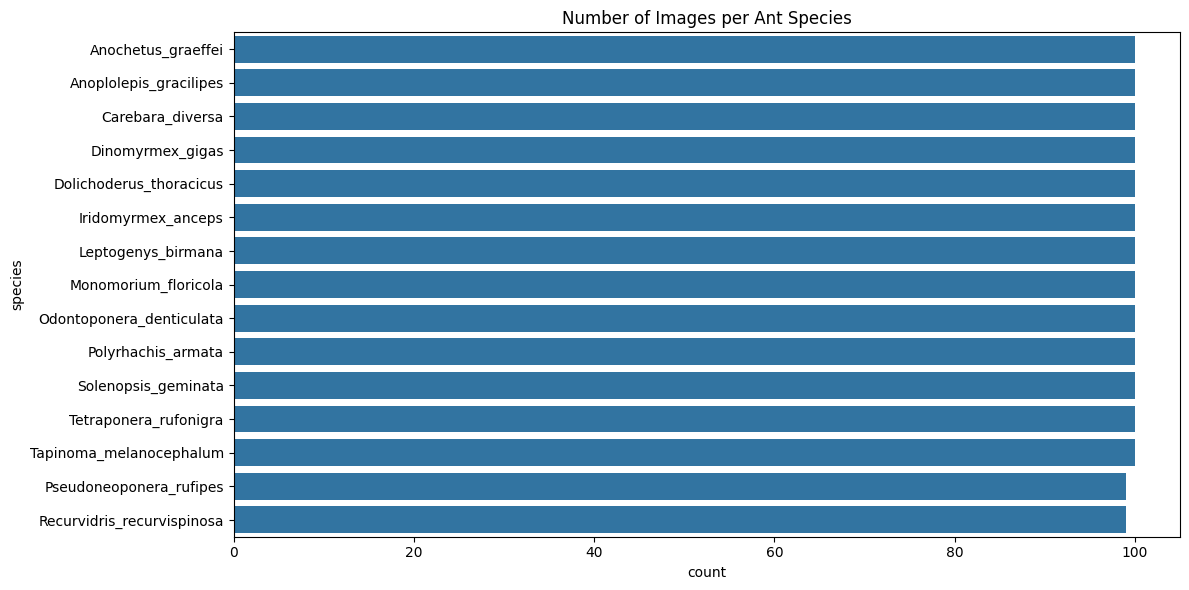

In [2]:
data_dir = 'data/'

# Get all species folders
species_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
print(f"Found {len(species_folders)} ant species: {species_folders}")

# Count images per species and collect image paths
species_counts = {}
image_paths = []
labels = []

for species in species_folders:
    species_dir = os.path.join(data_dir, species)
    image_files = [f for f in os.listdir(species_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    species_counts[species] = len(image_files)
    
    for img_file in image_files:
        image_paths.append(os.path.join(species_dir, img_file))
        labels.append(species)

# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'image_path': image_paths,
    'species': labels
})

print(f"Total images: {len(df)}")
print("\nClass distribution:")
print(df['species'].value_counts())

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='species', data=df, order=df['species'].value_counts().index)
plt.title('Number of Images per Ant Species')
plt.tight_layout()
plt.show()

### Image Properties Exploration

Analyzing images: 100%|██████████| 100/100 [00:00<00:00, 7597.69it/s]


Image properties summary:
            width      height
count  100.000000  100.000000
mean   324.310000  267.240000
std    126.835668  109.005895
min    135.000000  111.000000
25%    240.000000  175.750000
50%    240.000000  240.000000
75%    500.000000  333.000000
max    500.000000  500.000000

Image color modes:
mode
RGB    100
Name: count, dtype: int64


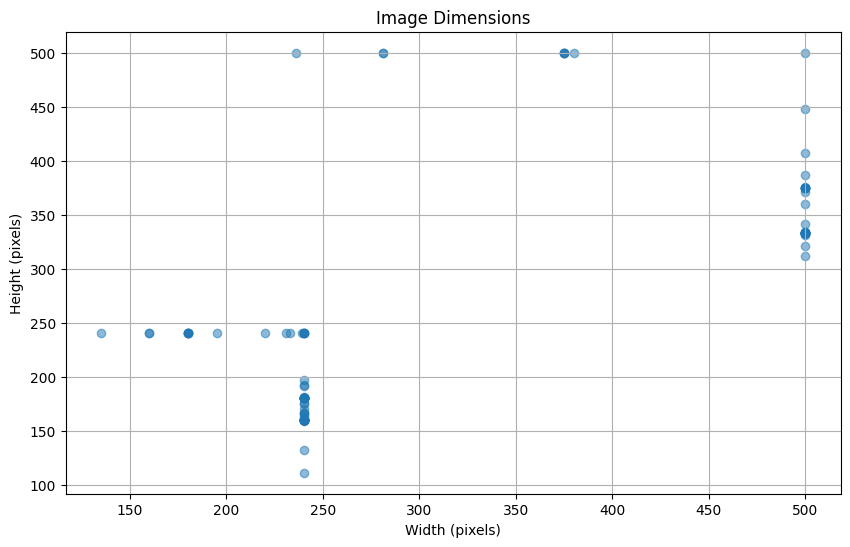

In [3]:
# Analyze image properties
def get_image_properties(image_path):
    try:
        img = Image.open(image_path)
        return {
            'width': img.width,
            'height': img.height,
            'mode': img.mode,
            'format': img.format
        }
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Sample a subset of images for analysis
sample_size = min(100, len(df))
sampled_images = df.sample(sample_size)['image_path'].tolist()

image_properties = []
for img_path in tqdm(sampled_images, desc="Analyzing images"):
    props = get_image_properties(img_path)
    if props:
        image_properties.append(props)

props_df = pd.DataFrame(image_properties)
print("\nImage properties summary:")
print(props_df.describe())

# Count image modes
print("\nImage color modes:")
print(props_df['mode'].value_counts())

# Plot image dimensions
plt.figure(figsize=(10, 6))
plt.scatter(props_df['width'], props_df['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

### Display Sample Images

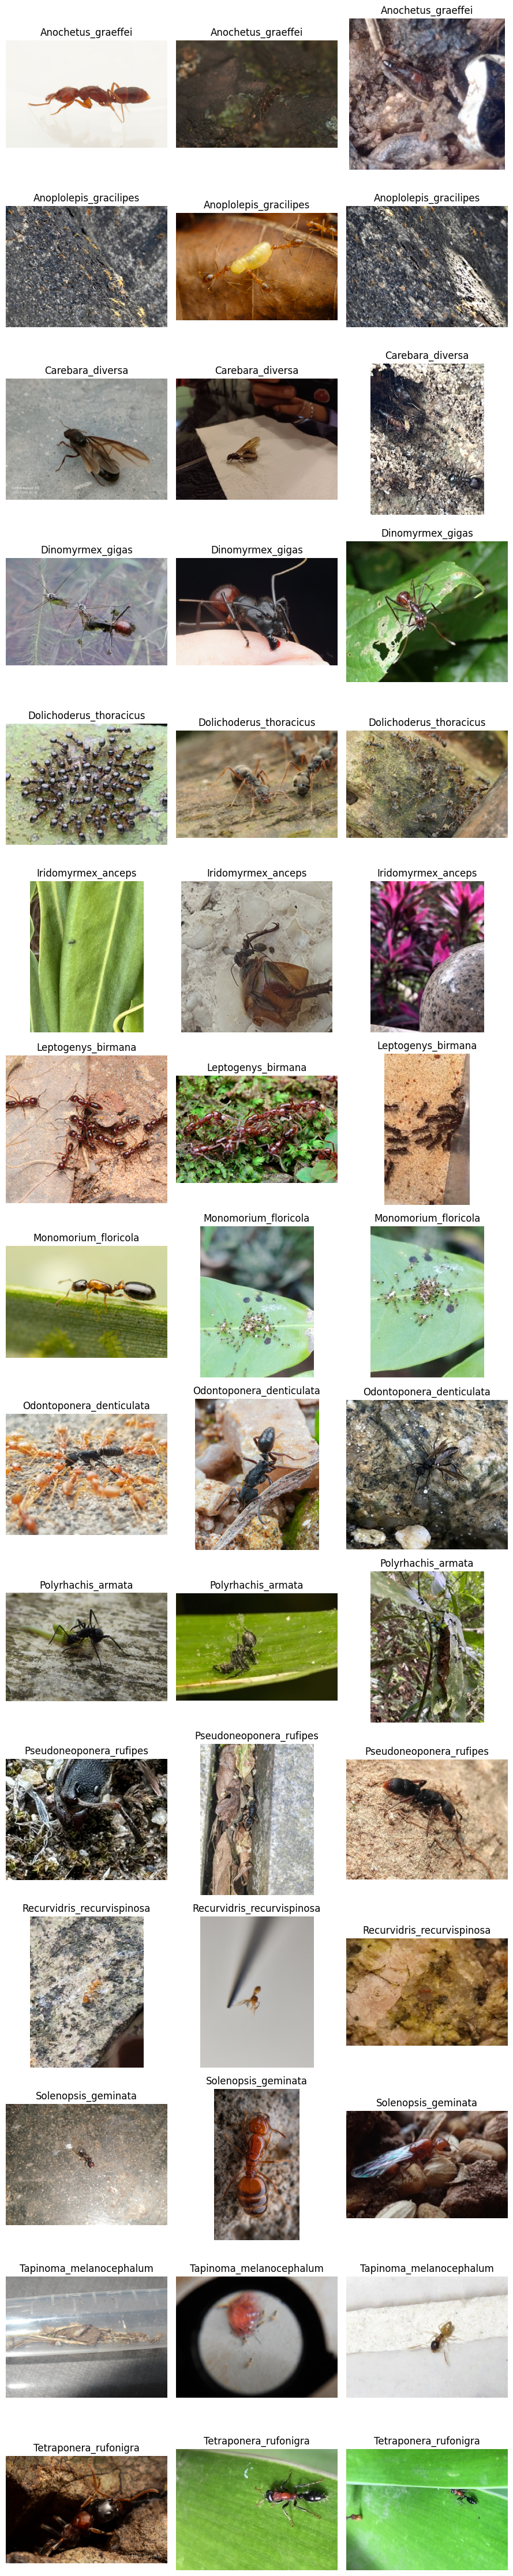

In [4]:
# Display sample images from each species
def show_sample_images(df, n_per_class=3):
    species_list = df['species'].unique()
    n_species = len(species_list)
    
    fig, axes = plt.subplots(n_species, n_per_class, figsize=(n_per_class*3, n_species*3))
    
    for i, species in enumerate(species_list):
        species_images = df[df['species'] == species]['image_path'].tolist()
        samples = random.sample(species_images, min(n_per_class, len(species_images)))
        
        for j, img_path in enumerate(samples):
            img = Image.open(img_path)
            if n_species > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
            ax.imshow(img)
            ax.set_title(f"{species}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images(df)

## Data Preprocessing and Dataset Creation

In [5]:
# Create label mapping
species_to_idx = {species: idx for idx, species in enumerate(sorted(df['species'].unique()))}
idx_to_species = {idx: species for species, idx in species_to_idx.items()}

print("Label mapping:")
for species, idx in species_to_idx.items():
    print(f"{species}: {idx}")

# Split data into train, validation, and test sets
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['species'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.15, stratify=train_val_df['species'], random_state=42)

print(f"\nTrain set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

Label mapping:
Anochetus_graeffei: 0
Anoplolepis_gracilipes: 1
Carebara_diversa: 2
Dinomyrmex_gigas: 3
Dolichoderus_thoracicus: 4
Iridomyrmex_anceps: 5
Leptogenys_birmana: 6
Monomorium_floricola: 7
Odontoponera_denticulata: 8
Polyrhachis_armata: 9
Pseudoneoponera_rufipes: 10
Recurvidris_recurvispinosa: 11
Solenopsis_geminata: 12
Tapinoma_melanocephalum: 13
Tetraponera_rufonigra: 14

Train set: 1082 images
Validation set: 191 images
Test set: 225 images


e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5528543].


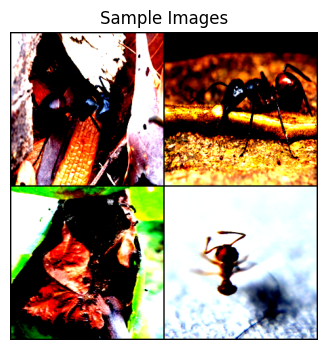

Sample labels:
Image 1: Dinomyrmex_gigas
Image 2: Dinomyrmex_gigas
Image 3: Dolichoderus_thoracicus
Image 4: Recurvidris_recurvispinosa


In [6]:
# Create custom dataset class with extreme optimizations
class AntSpeciesDataset(Dataset):
    def __init__(self, dataframe, transform=None, preload=False):
        self.img_paths = dataframe['image_path'].tolist()
        self.labels = [species_to_idx[species] for species in dataframe['species']]
        self.transform = transform

        # Preload all images into memory
        self.preloaded_images = None
        if preload:
            self.preloaded_images = []
            for path in self.img_paths:
                img = Image.open(path).convert('RGB')
                img = img.resize((224, 224), Image.BILINEAR)  # Resize
                self.preloaded_images.append(img)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Use preloaded image if available
        if self.preloaded_images is not None:
            image = self.preloaded_images[idx]
        else:
            # Load and resize
            image = Image.open(self.img_paths[idx]).convert('RGB')
            image = image.resize((224, 224), Image.BILINEAR)

        # Apply remaining transforms
        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

# Minimal transformations
train_transform = transforms.Compose([
    # Resize already done in dataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    # Resize already done in dataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = AntSpeciesDataset(train_df, transform=train_transform, preload=False)
val_dataset = AntSpeciesDataset(val_df, transform=val_test_transform, preload=True)
test_dataset = AntSpeciesDataset(test_df, transform=val_test_transform, preload=True)

# Create data loaders
batch_size = 16  # Reduced batch size
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # No multiprocessing overhead
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Simplified batch display
def show_batch(dataloader):
    for images, labels in dataloader:
        grid = torchvision.utils.make_grid(images[:4], nrow=2)
        plt.figure(figsize=(8, 4))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title('Sample Images')
        plt.axis('off')
        plt.show()

        print("Sample labels:")
        for i in range(min(4, len(labels))):
            print(f"Image {i+1}: {idx_to_species[labels[i].item()]}")
        break

show_batch(train_loader)

## Model Architectures

Implement multiple CNN architectures for comparison.

In [18]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a simple custom CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Function to create a pre-trained model with modified classifier
def create_pretrained_model(model_name, num_classes, freeze_backbone=True):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == 'efficientnet_b1':
        model = models.efficientnet_b1(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == 'mobilenet_v3_large':
        model = models.mobilenet_v3_large(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

    elif model_name == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

    elif model_name == 'squeezenet1_0':
        model = models.squeezenet1_0(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)

    elif model_name == 'mnasnet1_0':
        model = models.mnasnet1_0(pretrained=True)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model

# List of models to train
models_to_train = {
    'simple_cnn': SimpleCNN(num_classes=len(species_to_idx)),
    'resnet18': create_pretrained_model('resnet18', num_classes=len(species_to_idx)),
    'mobilenet_v2': create_pretrained_model('mobilenet_v2', num_classes=len(species_to_idx)),
    'efficientnet_b0': create_pretrained_model('efficientnet_b0', num_classes=len(species_to_idx)),
    'mobilenet_v3_small': create_pretrained_model('mobilenet_v3_small', num_classes=len(species_to_idx)),
    'squeezenet1_1': create_pretrained_model('squeezenet1_0', num_classes=len(species_to_idx)),
    'mnasnet1_0': create_pretrained_model('mnasnet1_0', num_classes=len(species_to_idx))
}

Using device: cpu


e:\Antify\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\thorung boonkaew/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:36<00:00, 284kB/s] 
e:\Antify\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\thorung boonkaew/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth


100%|██████████| 4.78M/4.78M [00:15<00:00, 331kB/s] 
e:\Antify\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to C:\Users\thorung boonkaew/.cache\torch\hub\checkpoints\mnasnet1.0_top1_73.512-f206786ef8.pth


100%|██████████| 16.9M/16.9M [00:56<00:00, 315kB/s] 


## Training and Validation

In [19]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, model_name="model"):
    model = model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best.pth")
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Load best model weights
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))
    return model, history

# Evaluation function
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc.item()

# Test function with detailed metrics
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Generate classification report
    class_names = [idx_to_species[i] for i in range(len(idx_to_species))]
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, report, cm, all_preds, all_labels

# Plot training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

## Model Training and Evaluation

Train each model and compare their performance.


Training simple_cnn


Epoch 1/10 - Training:   0%|          | 0/68 [00:00<?, ?it/s]e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]


Epoch 1/10 - Train Loss: 2.6975, Train Acc: 0.0786, Val Loss: 2.6620, Val Acc: 0.0838


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]


Epoch 2/10 - Train Loss: 2.5954, Train Acc: 0.1303, Val Loss: 2.4724, Val Acc: 0.1728


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  6.10it/s]


Epoch 3/10 - Train Loss: 2.4475, Train Acc: 0.1793, Val Loss: 2.4323, Val Acc: 0.2042


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.74it/s]


Epoch 4/10 - Train Loss: 2.3418, Train Acc: 0.2190, Val Loss: 2.3549, Val Acc: 0.1832


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.70it/s]


Epoch 5/10 - Train Loss: 2.1687, Train Acc: 0.2939, Val Loss: 2.2063, Val Acc: 0.2723


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.94it/s]


Epoch 6/10 - Train Loss: 1.9728, Train Acc: 0.3567, Val Loss: 2.1308, Val Acc: 0.2984


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


Epoch 7/10 - Train Loss: 1.7958, Train Acc: 0.4353, Val Loss: 2.1536, Val Acc: 0.3351


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.90it/s]


Epoch 8/10 - Train Loss: 1.5778, Train Acc: 0.5055, Val Loss: 1.9919, Val Acc: 0.4293


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  6.15it/s]


Epoch 9/10 - Train Loss: 1.2776, Train Acc: 0.5915, Val Loss: 1.8601, Val Acc: 0.4660


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]


Epoch 10/10 - Train Loss: 1.0596, Train Acc: 0.6636, Val Loss: 1.9741, Val Acc: 0.5026


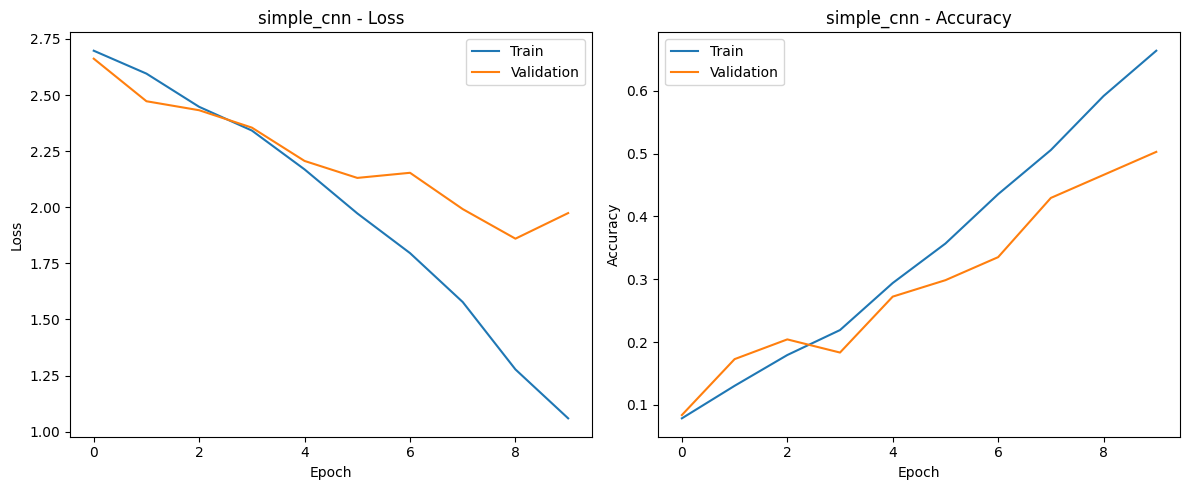

Testing: 100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


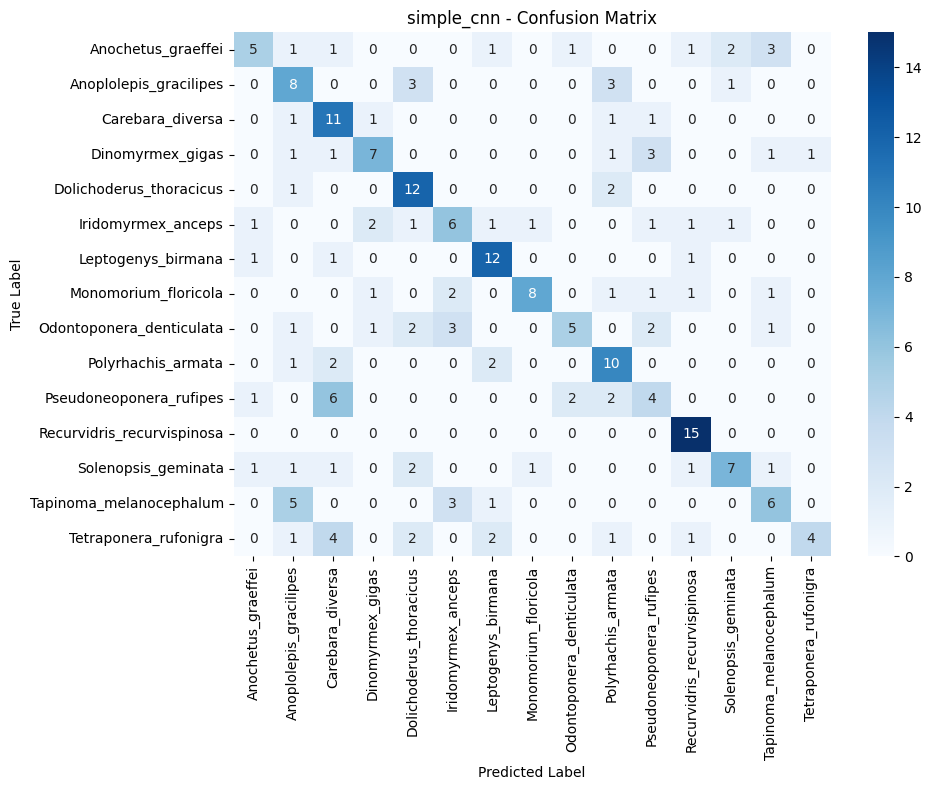


simple_cnn Test Accuracy: 0.5333

Classification Report:
                            precision    recall  f1-score     support
Anochetus_graeffei           0.555556  0.333333  0.416667   15.000000
Anoplolepis_gracilipes       0.380952  0.533333  0.444444   15.000000
Carebara_diversa             0.407407  0.733333  0.523810   15.000000
Dinomyrmex_gigas             0.583333  0.466667  0.518519   15.000000
Dolichoderus_thoracicus      0.545455  0.800000  0.648649   15.000000
Iridomyrmex_anceps           0.428571  0.400000  0.413793   15.000000
Leptogenys_birmana           0.631579  0.800000  0.705882   15.000000
Monomorium_floricola         0.800000  0.533333  0.640000   15.000000
Odontoponera_denticulata     0.625000  0.333333  0.434783   15.000000
Polyrhachis_armata           0.476190  0.666667  0.555556   15.000000
Pseudoneoponera_rufipes      0.333333  0.266667  0.296296   15.000000
Recurvidris_recurvispinosa   0.714286  1.000000  0.833333   15.000000
Solenopsis_geminata          0.6

Epoch 1/10 - Training:   0%|          | 0/68 [00:00<?, ?it/s]e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]


Epoch 1/10 - Train Loss: 2.5399, Train Acc: 0.1738, Val Loss: 2.1278, Val Acc: 0.3770


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch 2/10 - Train Loss: 1.8488, Train Acc: 0.4741, Val Loss: 1.8108, Val Acc: 0.4817


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 3/10 - Train Loss: 1.5118, Train Acc: 0.6109, Val Loss: 1.5967, Val Acc: 0.5288


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]


Epoch 4/10 - Train Loss: 1.2924, Train Acc: 0.6368, Val Loss: 1.4603, Val Acc: 0.5393


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]


Epoch 5/10 - Train Loss: 1.1904, Train Acc: 0.6719, Val Loss: 1.3684, Val Acc: 0.5812


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch 6/10 - Train Loss: 1.0376, Train Acc: 0.7357, Val Loss: 1.2982, Val Acc: 0.5916


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch 7/10 - Train Loss: 0.9667, Train Acc: 0.7412, Val Loss: 1.3052, Val Acc: 0.5969


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]


Epoch 8/10 - Train Loss: 0.8675, Train Acc: 0.7689, Val Loss: 1.2632, Val Acc: 0.6073


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]


Epoch 9/10 - Train Loss: 0.8187, Train Acc: 0.8013, Val Loss: 1.2448, Val Acc: 0.5812


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]


Epoch 10/10 - Train Loss: 0.7810, Train Acc: 0.7976, Val Loss: 1.1691, Val Acc: 0.6387


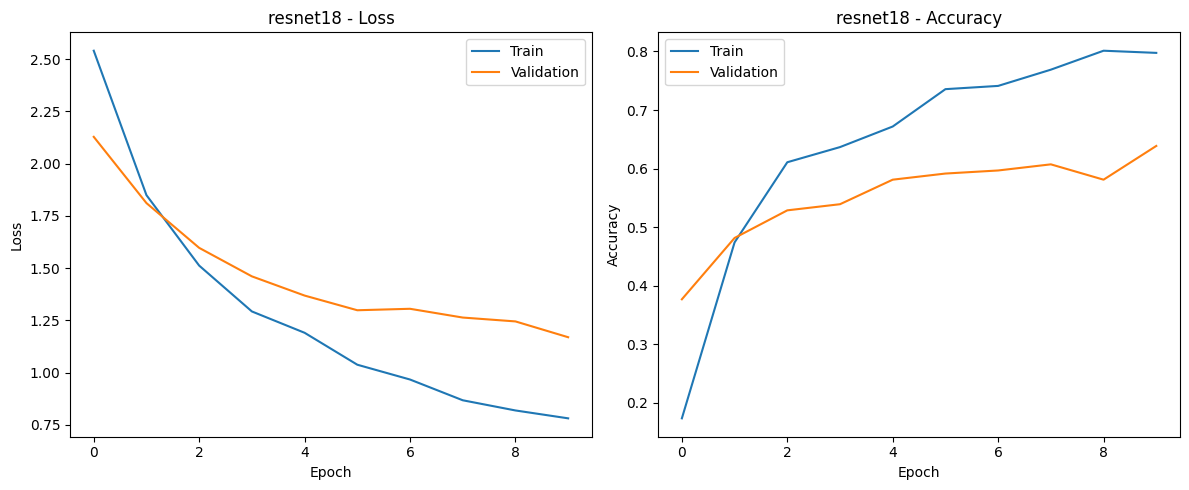

Testing: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


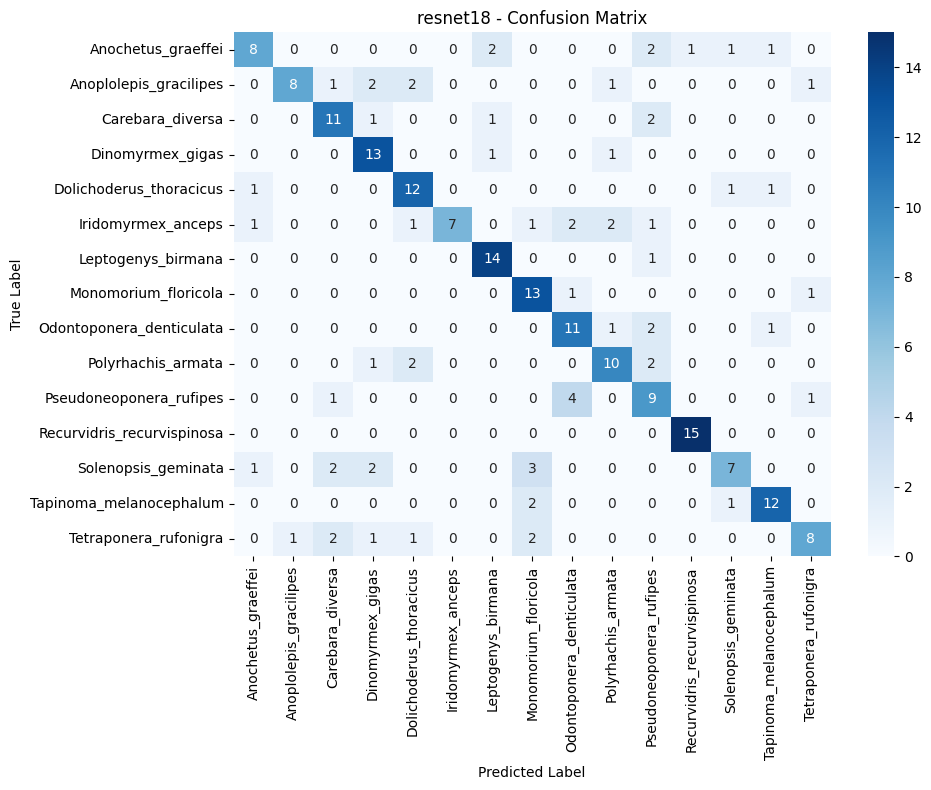


resnet18 Test Accuracy: 0.7022

Classification Report:
                            precision    recall  f1-score     support
Anochetus_graeffei           0.727273  0.533333  0.615385   15.000000
Anoplolepis_gracilipes       0.888889  0.533333  0.666667   15.000000
Carebara_diversa             0.647059  0.733333  0.687500   15.000000
Dinomyrmex_gigas             0.650000  0.866667  0.742857   15.000000
Dolichoderus_thoracicus      0.666667  0.800000  0.727273   15.000000
Iridomyrmex_anceps           1.000000  0.466667  0.636364   15.000000
Leptogenys_birmana           0.777778  0.933333  0.848485   15.000000
Monomorium_floricola         0.619048  0.866667  0.722222   15.000000
Odontoponera_denticulata     0.611111  0.733333  0.666667   15.000000
Polyrhachis_armata           0.666667  0.666667  0.666667   15.000000
Pseudoneoponera_rufipes      0.473684  0.600000  0.529412   15.000000
Recurvidris_recurvispinosa   0.937500  1.000000  0.967742   15.000000
Solenopsis_geminata          0.700

Epoch 1/10 - Training:   0%|          | 0/68 [00:00<?, ?it/s]e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]


Epoch 1/10 - Train Loss: 2.3274, Train Acc: 0.2810, Val Loss: 1.8324, Val Acc: 0.4712


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]


Epoch 2/10 - Train Loss: 1.5969, Train Acc: 0.5471, Val Loss: 1.4328, Val Acc: 0.6021


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.01it/s]


Epoch 3/10 - Train Loss: 1.2371, Train Acc: 0.6543, Val Loss: 1.2670, Val Acc: 0.6178


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch 4/10 - Train Loss: 1.0678, Train Acc: 0.7209, Val Loss: 1.1900, Val Acc: 0.6492


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch 5/10 - Train Loss: 0.9578, Train Acc: 0.7505, Val Loss: 1.0591, Val Acc: 0.6806


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]


Epoch 6/10 - Train Loss: 0.8578, Train Acc: 0.7523, Val Loss: 1.0286, Val Acc: 0.6754


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]


Epoch 7/10 - Train Loss: 0.7798, Train Acc: 0.7837, Val Loss: 0.9918, Val Acc: 0.7016


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.00it/s]


Epoch 8/10 - Train Loss: 0.7191, Train Acc: 0.7930, Val Loss: 0.9849, Val Acc: 0.6911


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch 9/10 - Train Loss: 0.6817, Train Acc: 0.8142, Val Loss: 0.9618, Val Acc: 0.7120


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.42it/s]


Epoch 10/10 - Train Loss: 0.6474, Train Acc: 0.8272, Val Loss: 0.8766, Val Acc: 0.7173


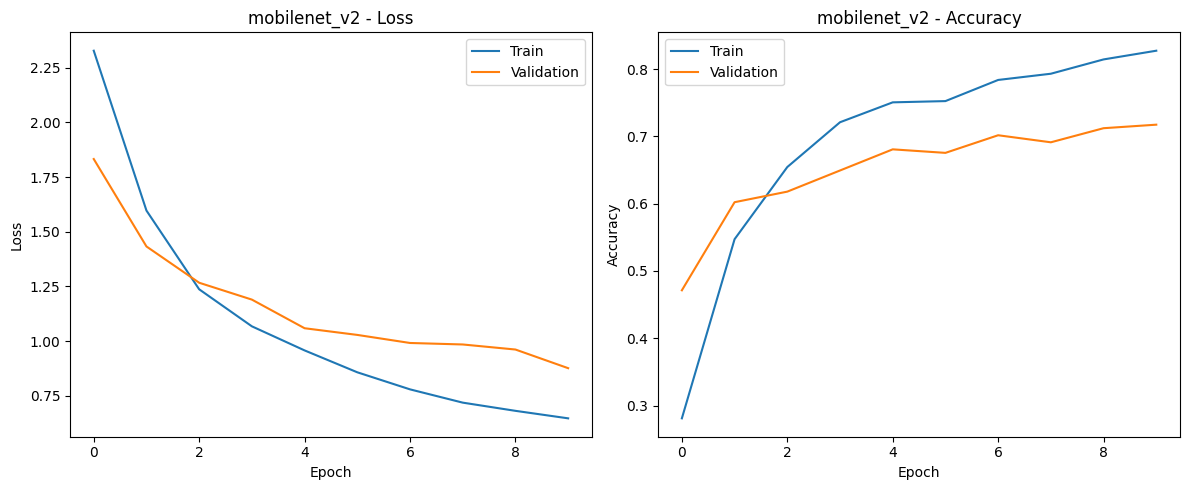

Testing: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


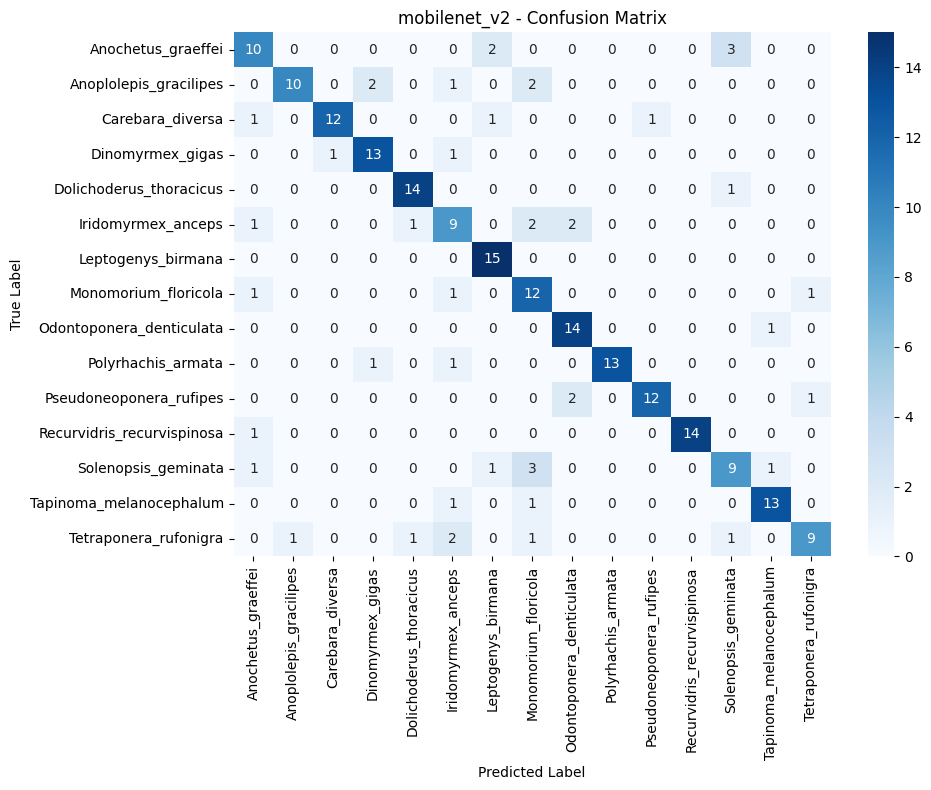


mobilenet_v2 Test Accuracy: 0.7956

Classification Report:
                            precision    recall  f1-score     support
Anochetus_graeffei           0.666667  0.666667  0.666667   15.000000
Anoplolepis_gracilipes       0.909091  0.666667  0.769231   15.000000
Carebara_diversa             0.923077  0.800000  0.857143   15.000000
Dinomyrmex_gigas             0.812500  0.866667  0.838710   15.000000
Dolichoderus_thoracicus      0.875000  0.933333  0.903226   15.000000
Iridomyrmex_anceps           0.562500  0.600000  0.580645   15.000000
Leptogenys_birmana           0.789474  1.000000  0.882353   15.000000
Monomorium_floricola         0.571429  0.800000  0.666667   15.000000
Odontoponera_denticulata     0.777778  0.933333  0.848485   15.000000
Polyrhachis_armata           1.000000  0.866667  0.928571   15.000000
Pseudoneoponera_rufipes      0.923077  0.800000  0.857143   15.000000
Recurvidris_recurvispinosa   1.000000  0.933333  0.965517   15.000000
Solenopsis_geminata          0

Epoch 1/10 - Training:   0%|          | 0/68 [00:00<?, ?it/s]e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Epoch 1/10 - Train Loss: 2.3855, Train Acc: 0.2717, Val Loss: 2.0022, Val Acc: 0.5026


Evaluating: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


Epoch 2/10 - Train Loss: 1.7865, Train Acc: 0.5388, Val Loss: 1.6713, Val Acc: 0.5864


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.23it/s]


Epoch 3/10 - Train Loss: 1.4594, Train Acc: 0.6562, Val Loss: 1.4855, Val Acc: 0.6230


Evaluating: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch 4/10 - Train Loss: 1.2740, Train Acc: 0.6932, Val Loss: 1.3832, Val Acc: 0.6387


Evaluating: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 5/10 - Train Loss: 1.1169, Train Acc: 0.7421, Val Loss: 1.2869, Val Acc: 0.6859


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


Epoch 6/10 - Train Loss: 1.0350, Train Acc: 0.7431, Val Loss: 1.2179, Val Acc: 0.6911


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Epoch 7/10 - Train Loss: 0.9322, Train Acc: 0.7837, Val Loss: 1.1865, Val Acc: 0.6963


Evaluating: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 8/10 - Train Loss: 0.8677, Train Acc: 0.7967, Val Loss: 1.1070, Val Acc: 0.7225


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Epoch 9/10 - Train Loss: 0.8254, Train Acc: 0.8078, Val Loss: 1.0945, Val Acc: 0.6911


Evaluating: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 10/10 - Train Loss: 0.7836, Train Acc: 0.8124, Val Loss: 1.0703, Val Acc: 0.6963


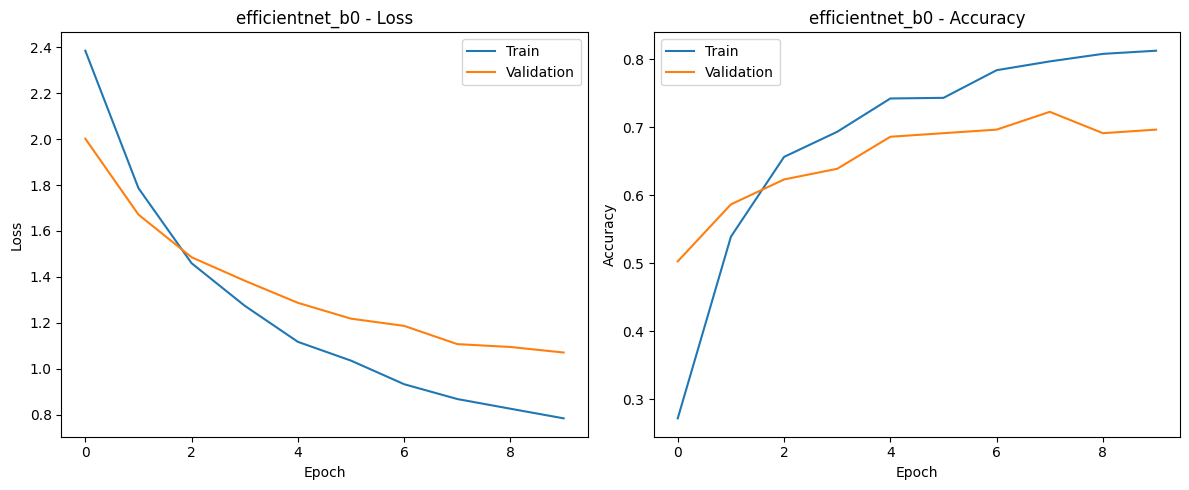

Testing: 100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


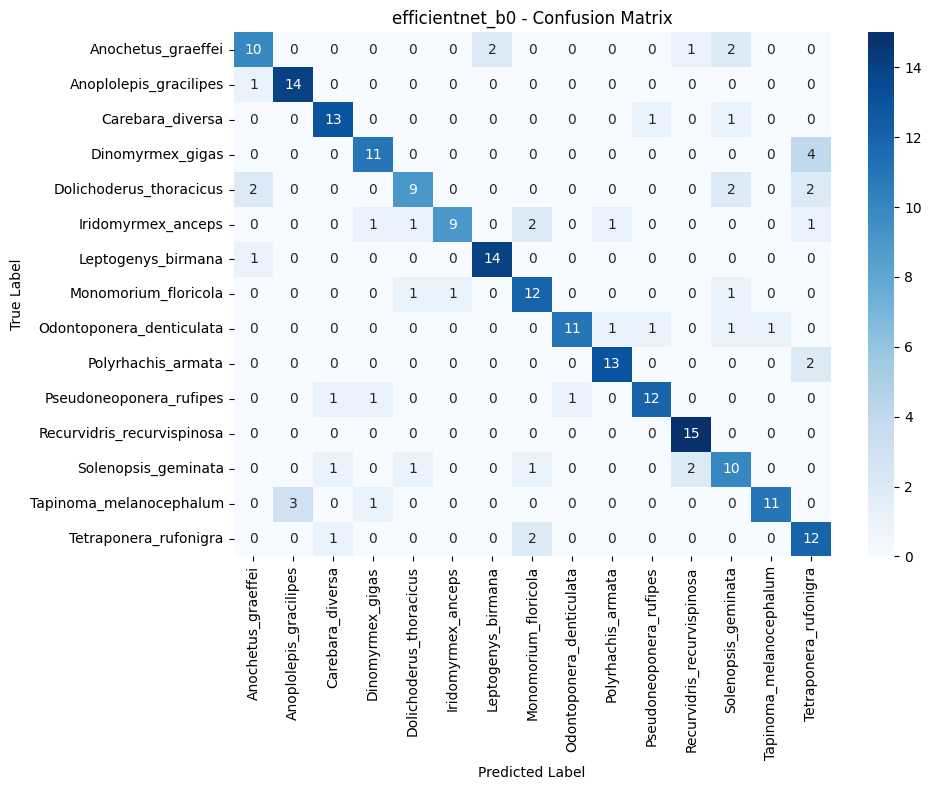


efficientnet_b0 Test Accuracy: 0.7822

Classification Report:
                            precision    recall  f1-score     support
Anochetus_graeffei           0.714286  0.666667  0.689655   15.000000
Anoplolepis_gracilipes       0.823529  0.933333  0.875000   15.000000
Carebara_diversa             0.812500  0.866667  0.838710   15.000000
Dinomyrmex_gigas             0.785714  0.733333  0.758621   15.000000
Dolichoderus_thoracicus      0.750000  0.600000  0.666667   15.000000
Iridomyrmex_anceps           0.900000  0.600000  0.720000   15.000000
Leptogenys_birmana           0.875000  0.933333  0.903226   15.000000
Monomorium_floricola         0.705882  0.800000  0.750000   15.000000
Odontoponera_denticulata     0.916667  0.733333  0.814815   15.000000
Polyrhachis_armata           0.866667  0.866667  0.866667   15.000000
Pseudoneoponera_rufipes      0.857143  0.800000  0.827586   15.000000
Recurvidris_recurvispinosa   0.833333  1.000000  0.909091   15.000000
Solenopsis_geminata        

Epoch 1/10 - Training:   0%|          | 0/68 [00:00<?, ?it/s]e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 12/12 [00:00<00:00, 13.60it/s]


Epoch 1/10 - Train Loss: 2.3067, Train Acc: 0.3050, Val Loss: 1.8428, Val Acc: 0.4921


Evaluating: 100%|██████████| 12/12 [00:01<00:00, 11.32it/s]


Epoch 2/10 - Train Loss: 1.5997, Train Acc: 0.5989, Val Loss: 1.4718, Val Acc: 0.5864


Evaluating: 100%|██████████| 12/12 [00:01<00:00, 11.23it/s]


Epoch 3/10 - Train Loss: 1.2581, Train Acc: 0.7006, Val Loss: 1.2780, Val Acc: 0.6702


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.56it/s]


Epoch 4/10 - Train Loss: 1.0635, Train Acc: 0.7616, Val Loss: 1.1800, Val Acc: 0.6859


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.28it/s]


Epoch 5/10 - Train Loss: 0.9665, Train Acc: 0.7717, Val Loss: 1.1232, Val Acc: 0.6859


Evaluating: 100%|██████████| 12/12 [00:01<00:00, 10.35it/s]


Epoch 6/10 - Train Loss: 0.8248, Train Acc: 0.8161, Val Loss: 1.0542, Val Acc: 0.7016


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 13.73it/s]


Epoch 7/10 - Train Loss: 0.7604, Train Acc: 0.8244, Val Loss: 1.0151, Val Acc: 0.7068


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 13.75it/s]


Epoch 8/10 - Train Loss: 0.6991, Train Acc: 0.8373, Val Loss: 0.9878, Val Acc: 0.6963


Evaluating: 100%|██████████| 12/12 [00:01<00:00, 11.11it/s]


Epoch 9/10 - Train Loss: 0.6278, Train Acc: 0.8586, Val Loss: 0.9523, Val Acc: 0.7225


Evaluating: 100%|██████████| 12/12 [00:01<00:00, 10.64it/s]


Epoch 10/10 - Train Loss: 0.5472, Train Acc: 0.9002, Val Loss: 0.9314, Val Acc: 0.7277


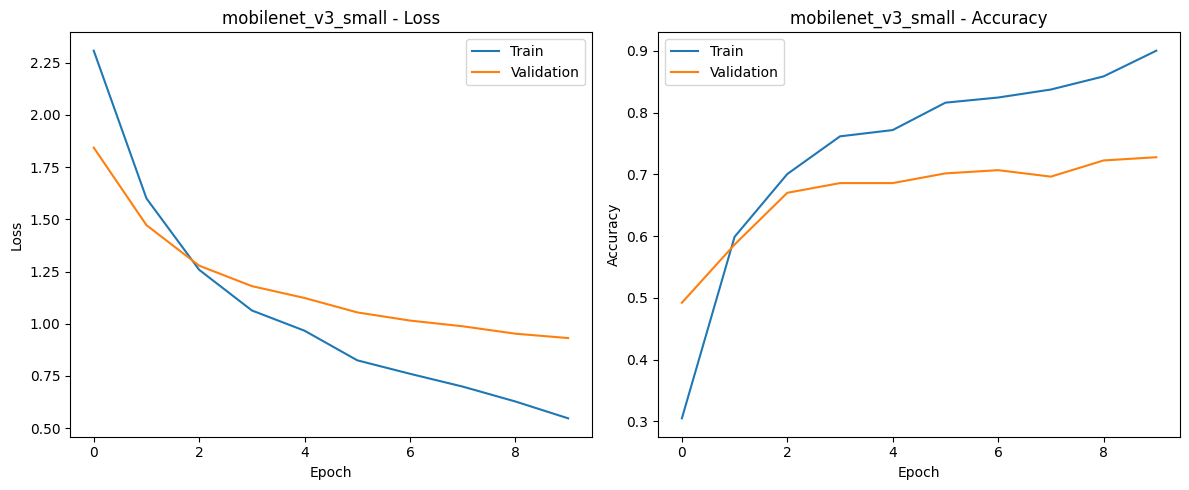

Testing: 100%|██████████| 15/15 [00:01<00:00, 11.46it/s]


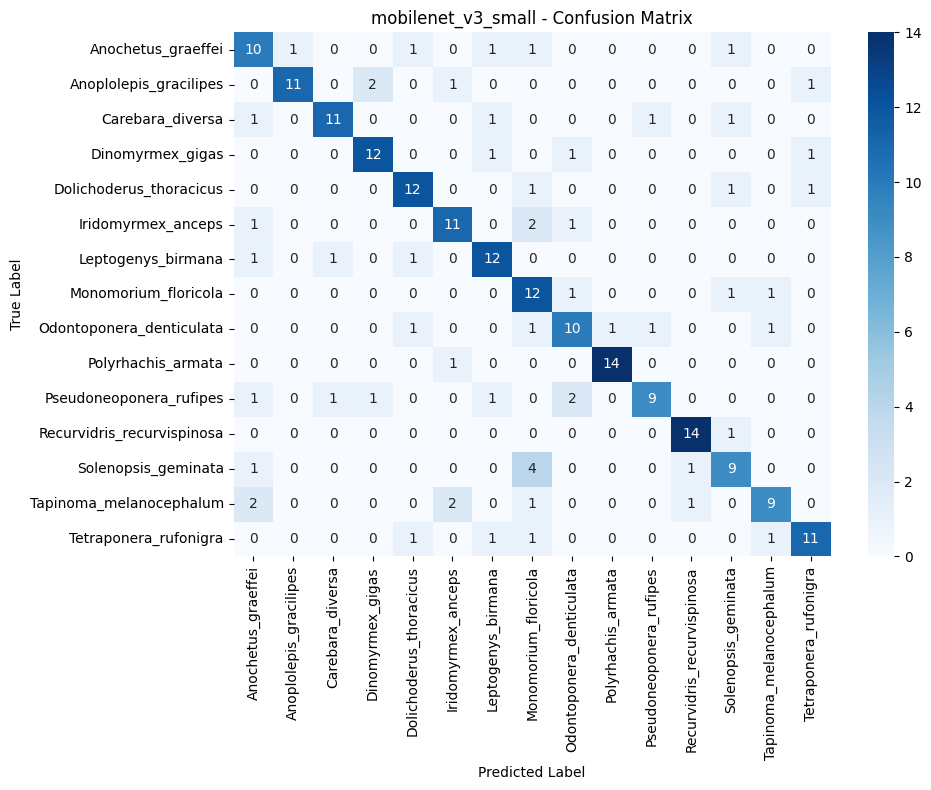


mobilenet_v3_small Test Accuracy: 0.7422

Classification Report:
                            precision    recall  f1-score     support
Anochetus_graeffei           0.588235  0.666667  0.625000   15.000000
Anoplolepis_gracilipes       0.916667  0.733333  0.814815   15.000000
Carebara_diversa             0.846154  0.733333  0.785714   15.000000
Dinomyrmex_gigas             0.800000  0.800000  0.800000   15.000000
Dolichoderus_thoracicus      0.750000  0.800000  0.774194   15.000000
Iridomyrmex_anceps           0.733333  0.733333  0.733333   15.000000
Leptogenys_birmana           0.705882  0.800000  0.750000   15.000000
Monomorium_floricola         0.521739  0.800000  0.631579   15.000000
Odontoponera_denticulata     0.666667  0.666667  0.666667   15.000000
Polyrhachis_armata           0.933333  0.933333  0.933333   15.000000
Pseudoneoponera_rufipes      0.818182  0.600000  0.692308   15.000000
Recurvidris_recurvispinosa   0.875000  0.933333  0.903226   15.000000
Solenopsis_geminata     

Epoch 1/10 - Training:   0%|          | 0/68 [00:00<?, ?it/s]e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


Epoch 1/10 - Train Loss: 2.4444, Train Acc: 0.2588, Val Loss: 1.8454, Val Acc: 0.4817


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]


Epoch 2/10 - Train Loss: 1.4975, Train Acc: 0.5619, Val Loss: 1.3608, Val Acc: 0.5916


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]


Epoch 3/10 - Train Loss: 1.0305, Train Acc: 0.6996, Val Loss: 1.1722, Val Acc: 0.6597


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]


Epoch 4/10 - Train Loss: 0.8032, Train Acc: 0.7800, Val Loss: 1.0723, Val Acc: 0.6911


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]


Epoch 5/10 - Train Loss: 0.6485, Train Acc: 0.8299, Val Loss: 1.0322, Val Acc: 0.7068


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch 6/10 - Train Loss: 0.5265, Train Acc: 0.8669, Val Loss: 0.9795, Val Acc: 0.7277


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.00it/s]


Epoch 7/10 - Train Loss: 0.4522, Train Acc: 0.8780, Val Loss: 0.8751, Val Acc: 0.7592


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch 8/10 - Train Loss: 0.3865, Train Acc: 0.9085, Val Loss: 0.9315, Val Acc: 0.7487


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch 9/10 - Train Loss: 0.3314, Train Acc: 0.9288, Val Loss: 0.8813, Val Acc: 0.7487


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]


Epoch 10/10 - Train Loss: 0.2939, Train Acc: 0.9362, Val Loss: 0.8055, Val Acc: 0.7958


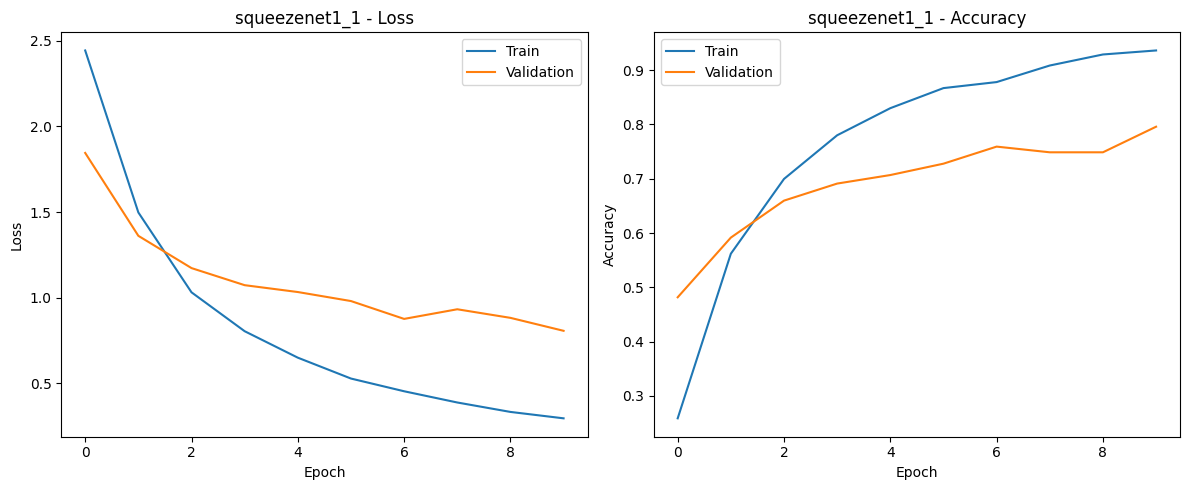

Testing: 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


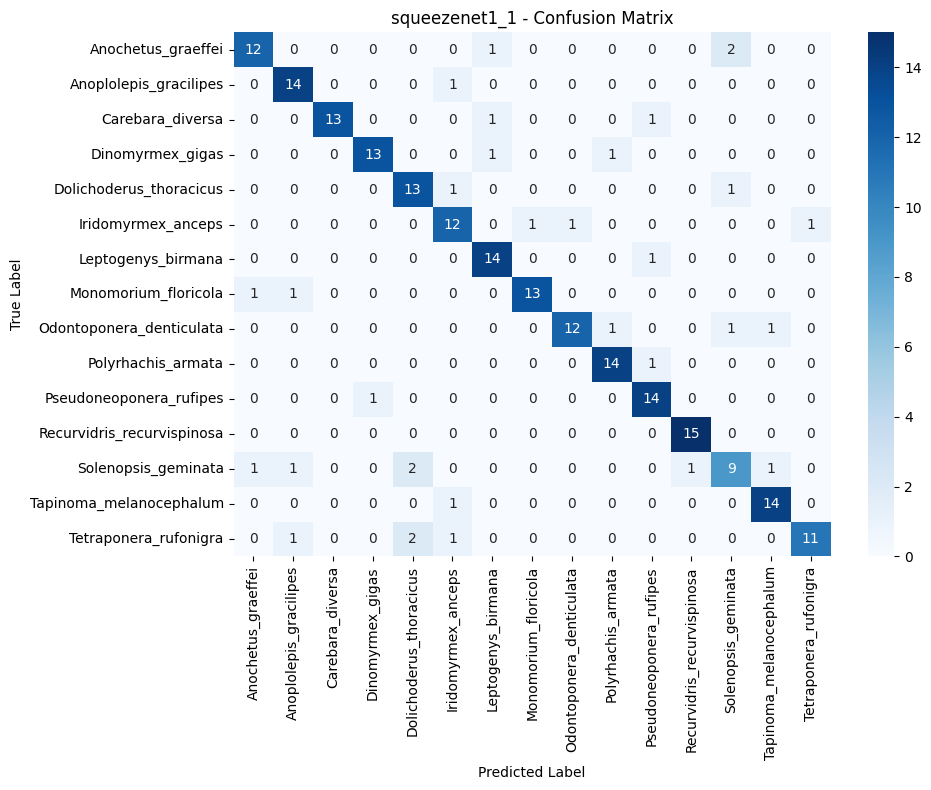


squeezenet1_1 Test Accuracy: 0.8578

Classification Report:
                            precision    recall  f1-score     support
Anochetus_graeffei           0.857143  0.800000  0.827586   15.000000
Anoplolepis_gracilipes       0.823529  0.933333  0.875000   15.000000
Carebara_diversa             1.000000  0.866667  0.928571   15.000000
Dinomyrmex_gigas             0.928571  0.866667  0.896552   15.000000
Dolichoderus_thoracicus      0.764706  0.866667  0.812500   15.000000
Iridomyrmex_anceps           0.750000  0.800000  0.774194   15.000000
Leptogenys_birmana           0.823529  0.933333  0.875000   15.000000
Monomorium_floricola         0.928571  0.866667  0.896552   15.000000
Odontoponera_denticulata     0.923077  0.800000  0.857143   15.000000
Polyrhachis_armata           0.875000  0.933333  0.903226   15.000000
Pseudoneoponera_rufipes      0.823529  0.933333  0.875000   15.000000
Recurvidris_recurvispinosa   0.937500  1.000000  0.967742   15.000000
Solenopsis_geminata          

Epoch 1/10 - Training:   0%|          | 0/68 [00:00<?, ?it/s]e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]


Epoch 1/10 - Train Loss: 2.3762, Train Acc: 0.2847, Val Loss: 2.0396, Val Acc: 0.4398


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Epoch 2/10 - Train Loss: 1.7083, Train Acc: 0.5471, Val Loss: 1.7533, Val Acc: 0.4712


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


Epoch 3/10 - Train Loss: 1.3874, Train Acc: 0.6590, Val Loss: 1.5674, Val Acc: 0.5079


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s]


Epoch 4/10 - Train Loss: 1.1843, Train Acc: 0.7015, Val Loss: 1.5023, Val Acc: 0.5288


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]


Epoch 5/10 - Train Loss: 1.0440, Train Acc: 0.7412, Val Loss: 1.3738, Val Acc: 0.5864


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Epoch 6/10 - Train Loss: 0.9624, Train Acc: 0.7726, Val Loss: 1.3563, Val Acc: 0.5497


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.50it/s]


Epoch 7/10 - Train Loss: 0.8489, Train Acc: 0.7939, Val Loss: 1.2753, Val Acc: 0.5864


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch 8/10 - Train Loss: 0.8006, Train Acc: 0.8050, Val Loss: 1.2690, Val Acc: 0.6073


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


Epoch 9/10 - Train Loss: 0.7108, Train Acc: 0.8318, Val Loss: 1.2694, Val Acc: 0.5759


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch 10/10 - Train Loss: 0.6866, Train Acc: 0.8355, Val Loss: 1.1992, Val Acc: 0.6178


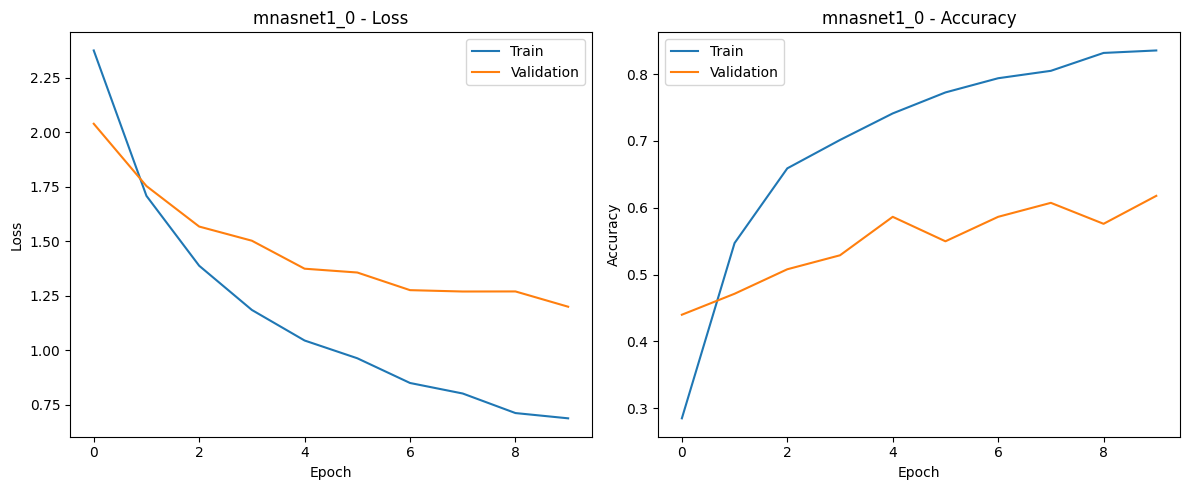

Testing: 100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


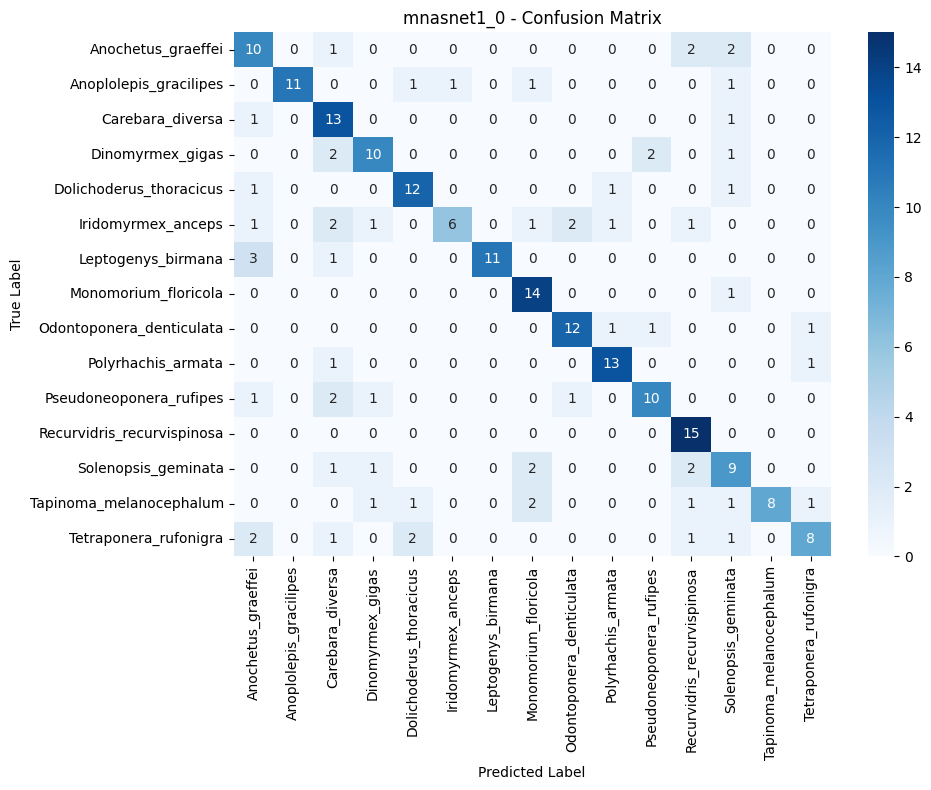


mnasnet1_0 Test Accuracy: 0.7200

Classification Report:
                            precision    recall  f1-score  support
Anochetus_graeffei           0.526316  0.666667  0.588235    15.00
Anoplolepis_gracilipes       1.000000  0.733333  0.846154    15.00
Carebara_diversa             0.541667  0.866667  0.666667    15.00
Dinomyrmex_gigas             0.714286  0.666667  0.689655    15.00
Dolichoderus_thoracicus      0.750000  0.800000  0.774194    15.00
Iridomyrmex_anceps           0.857143  0.400000  0.545455    15.00
Leptogenys_birmana           1.000000  0.733333  0.846154    15.00
Monomorium_floricola         0.700000  0.933333  0.800000    15.00
Odontoponera_denticulata     0.800000  0.800000  0.800000    15.00
Polyrhachis_armata           0.812500  0.866667  0.838710    15.00
Pseudoneoponera_rufipes      0.769231  0.666667  0.714286    15.00
Recurvidris_recurvispinosa   0.681818  1.000000  0.810811    15.00
Solenopsis_geminata          0.500000  0.600000  0.545455    15.00
Tapi

In [20]:
# Set hyperparameters
num_epochs = 10
learning_rate = 0.001
weight_decay = 1e-4

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models_to_train.items():
    print(f"\n{'='*50}\nTraining {model_name}\n{'='*50}")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Fix: Remove verbose parameter
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # Train the model
    trained_model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        num_epochs=num_epochs, model_name=model_name
    )

    # Plot training history
    plot_training_history(history, model_name)

    # Test the model
    accuracy, report, cm, all_preds, all_labels = test_model(trained_model, test_loader)

    # Plot confusion matrix
    class_names = [idx_to_species[i] for i in range(len(idx_to_species))]
    plot_confusion_matrix(cm, class_names, model_name)

    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'report': report,
        'history': history
    }

    print(f"\n{model_name} Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(pd.DataFrame(report).T)

## Results Comparison and Analysis

Model Performance Comparison:
                Model  Accuracy  F1 Score (Macro)
0       squeezenet1_1  0.857778          0.856664
1        mobilenet_v2  0.795556          0.796268
2     efficientnet_b0  0.782222          0.781768
3  mobilenet_v3_small  0.742222          0.743743
4          mnasnet1_0  0.720000          0.718454
5            resnet18  0.702222          0.696842
6          simple_cnn  0.533333          0.519918


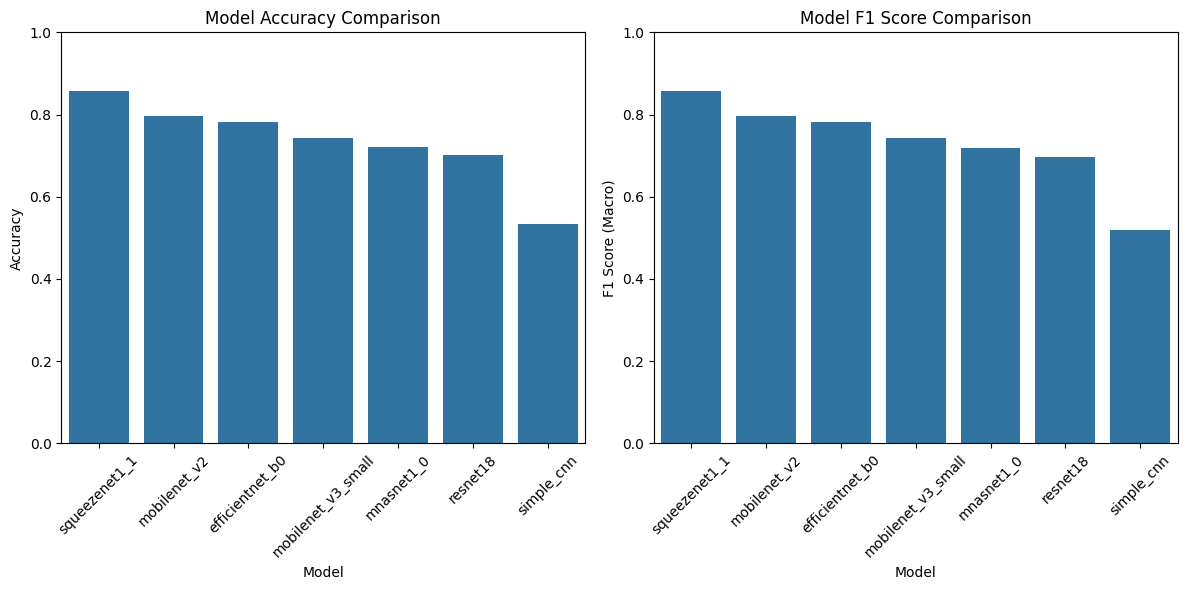


Best performing model: squeezenet1_1
Accuracy: 0.8578
F1 Score: 0.8567


In [21]:
# Compare model performances
model_accuracies = {model_name: results[model_name]['accuracy'] for model_name in results}
model_f1_scores = {model_name: results[model_name]['report']['macro avg']['f1-score'] for model_name in results}

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(model_accuracies.keys()),
    'Accuracy': list(model_accuracies.values()),
    'F1 Score (Macro)': list(model_f1_scores.values())
})

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("Model Performance Comparison:")
print(comparison_df)

# Plot model comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='F1 Score (Macro)', data=comparison_df)
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")
print(f"Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"F1 Score: {comparison_df.iloc[0]['F1 Score (Macro)']:.4f}")

## Visualize Model Predictions

e:\Antify\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


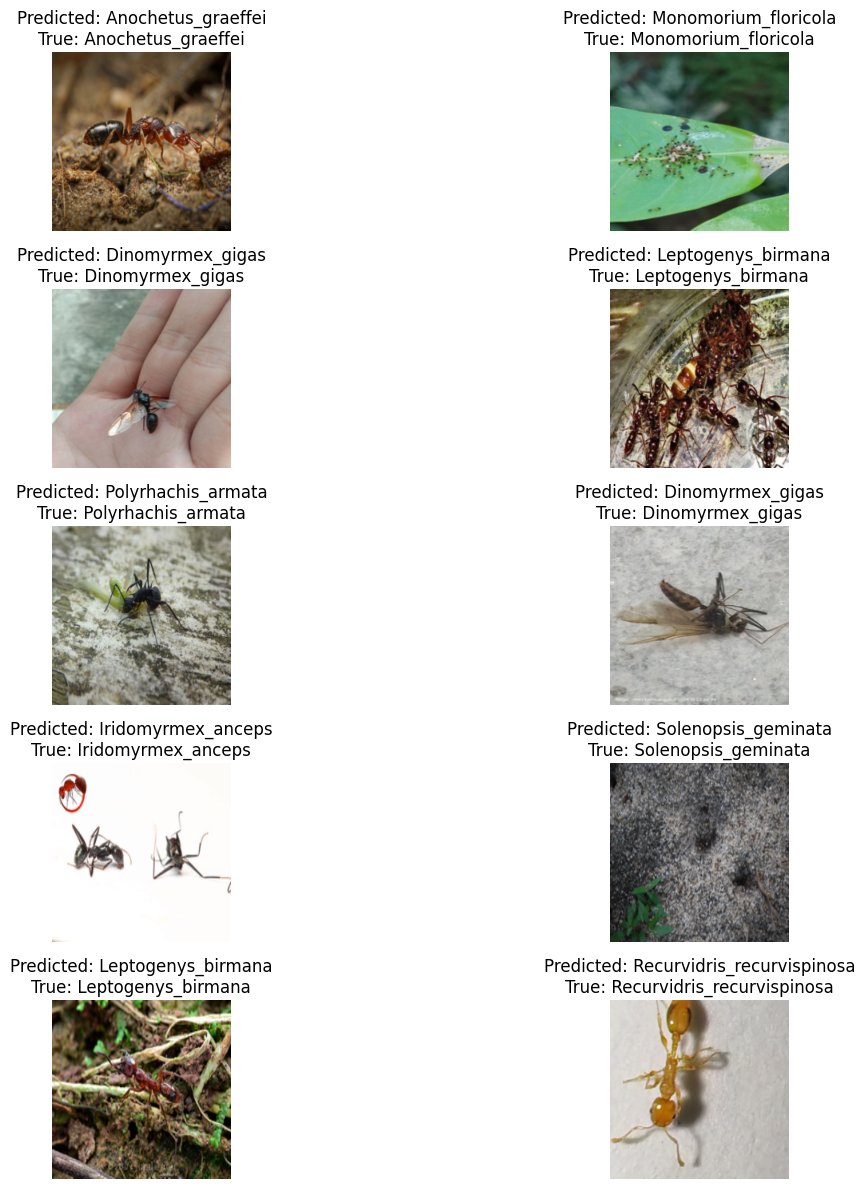

In [22]:
# Load the best model
best_model = models_to_train[best_model_name]
best_model.load_state_dict(torch.load(f"{best_model_name}_best.pth"))
best_model = best_model.to(device)
best_model.eval()

# Function to visualize predictions
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 12))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {idx_to_species[preds[j].item()]}\nTrue: {idx_to_species[labels[j].item()]}')
                
                # Denormalize image for display
                img = inputs.cpu().data[j].clone()
                img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                img = img.numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)
                
                ax.imshow(img)
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    return
    plt.tight_layout()

# Visualize predictions on test set
visualize_predictions(best_model, test_loader)

## Model Saving and Loading

In [23]:
# Save the best model with metadata
def save_model_with_metadata(model, model_name, species_mapping, transform):
    # Save model state dict
    torch.save(model.state_dict(), f"{model_name}_final.pth")
    
    # Save metadata
    metadata = {
        'model_name': model_name,
        'species_mapping': species_mapping,
        'num_classes': len(species_mapping),
        'input_size': (224, 224),
        'normalize_mean': [0.485, 0.456, 0.406],
        'normalize_std': [0.229, 0.224, 0.225]
    }
    
    with open(f"{model_name}_metadata.json", 'w') as f:
        json.dump(metadata, f)
    
    print(f"Model and metadata saved as {model_name}_final.pth and {model_name}_metadata.json")

# Function to load model for inference
def load_model_for_inference(model_name):
    # Load metadata
    with open(f"{model_name}_metadata.json", 'r') as f:
        metadata = json.load(f)
    
    # Create model
    if model_name == 'simple_cnn':
        model = SimpleCNN(num_classes=metadata['num_classes'])
    else:
        model = create_pretrained_model(model_name, num_classes=metadata['num_classes'], freeze_backbone=False)
    
    # Load state dict
    model.load_state_dict(torch.load(f"{model_name}_final.pth"))
    model.eval()
    
    # Create transform
    transform = transforms.Compose([
        transforms.Resize(metadata['input_size']),
        transforms.ToTensor(),
        transforms.Normalize(mean=metadata['normalize_mean'], std=metadata['normalize_std'])
    ])
    
    return model, transform, metadata['species_mapping']

# Save the best model
import json
save_model_with_metadata(best_model, best_model_name, idx_to_species, val_test_transform)

Model and metadata saved as squeezenet1_1_final.pth and squeezenet1_1_metadata.json


## Unit Tests

In [24]:
# Define unit tests
class TestAntSpeciesClassification(unittest.TestCase):
    def setUp(self):
        # Load a small subset of data for testing
        self.test_df = test_df.sample(min(10, len(test_df)))
        self.test_dataset = AntSpeciesDataset(self.test_df, transform=val_test_transform)
        self.test_loader = DataLoader(self.test_dataset, batch_size=2, shuffle=False)
        
        # Load model
        self.model_name = best_model_name
        self.model = models_to_train[self.model_name]
        self.model.load_state_dict(torch.load(f"{self.model_name}_best.pth"))
        self.model = self.model.to(device)
        self.model.eval()
    
    def test_dataset_creation(self):
        """Test that dataset is created correctly"""
        self.assertEqual(len(self.test_dataset), len(self.test_df))
        img, label = self.test_dataset[0]
        self.assertEqual(img.shape, torch.Size([3, 224, 224]))
        self.assertIsInstance(label, int)
    
    def test_model_output_shape(self):
        """Test that model outputs correct shape"""
        with torch.no_grad():
            for inputs, _ in self.test_loader:
                inputs = inputs.to(device)
                outputs = self.model(inputs)
                self.assertEqual(outputs.shape[1], len(species_to_idx))
                break
    
    def test_prediction_pipeline(self):
        """Test the full prediction pipeline"""
        # Get a sample image
        sample_path = self.test_df.iloc[0]['image_path']
        true_species = self.test_df.iloc[0]['species']
        
        # Load and transform image
        image = Image.open(sample_path).convert('RGB')
        image_tensor = val_test_transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = self.model(image_tensor)
            _, preds = torch.max(outputs, 1)
            predicted_species = idx_to_species[preds.item()]
        
        # Check that prediction is a valid species
        self.assertIn(predicted_species, species_to_idx.keys())
    
    def test_model_loading(self):
        """Test that model can be loaded from saved files"""
        # Save model
        save_model_with_metadata(self.model, self.model_name, idx_to_species, val_test_transform)
        
        # Load model
        loaded_model, transform, species_mapping = load_model_for_inference(self.model_name)
        loaded_model = loaded_model.to(device)
        loaded_model.eval()
        
        # Check that species mapping is correct
        self.assertEqual(species_mapping, idx_to_species)
        
        # Check that model makes same predictions
        with torch.no_grad():
            for inputs, _ in self.test_loader:
                inputs = inputs.to(device)
                
                # Original model prediction
                original_outputs = self.model(inputs)
                _, original_preds = torch.max(original_outputs, 1)
                
                # Loaded model prediction
                loaded_outputs = loaded_model(inputs)
                _, loaded_preds = torch.max(loaded_outputs, 1)
                
                # Check that predictions match
                self.assertTrue(torch.all(original_preds == loaded_preds))
                break

# Run the tests
unittest.main(argv=['first-arg-is-ignored'], exit=False)

.E.

Model and metadata saved as squeezenet1_1_final.pth and squeezenet1_1_metadata.json


.
ERROR: test_model_loading (__main__.TestAntSpeciesClassification.test_model_loading)
Test that model can be loaded from saved files
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\thorung boonkaew\AppData\Local\Temp\ipykernel_13132\3746883768.py", line 57, in test_model_loading
    loaded_model, transform, species_mapping = load_model_for_inference(self.model_name)
                                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\thorung boonkaew\AppData\Local\Temp\ipykernel_13132\664024998.py", line 31, in load_model_for_inference
    model = create_pretrained_model(model_name, num_classes=metadata['num_classes'], freeze_backbone=False)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\thorung boonkaew\AppData\Local\Temp\ipykernel_13132\1169029381.py", line 119, in create_pretrained_model
    ret

# Task 1.4: Model Versioning and Experimentation

In [69]:
import os
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
from sklearn.metrics import accuracy_score

In [70]:
# Define dataset and transformations
data_dir = "data/"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [71]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

In [72]:
# Train & evaluate function
def train_and_evaluate(model, optimizer, criterion, epochs=3):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    acc = accuracy_score(true_labels, predictions)
    return acc

In [74]:
mlflow.set_tracking_uri("file:./mlruns")

In [76]:
experiment_name = "ant_species_identification"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///e:/Antify/AntifyBackend/mlruns/177611422238966225', creation_time=1746890806420, experiment_id='177611422238966225', last_update_time=1746890806420, lifecycle_stage='active', name='ant_species_identification', tags={}>

In [77]:
# Run experiments with different versions of SqueezeNet1_1
results = {}
versions = {
    "squeezenet_v1": {"lr": 0.001, "epochs": 3},
    "squeezenet_v2": {"lr": 0.0005, "epochs": 5},
    "squeezenet_v3": {"lr": 0.0001, "epochs": 7},
}

In [78]:
for version_name, params in versions.items():
    with mlflow.start_run(run_name=version_name):
        model = models.squeezenet1_1(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, len(dataset.classes), kernel_size=1)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params["lr"])

        acc = train_and_evaluate(model, optimizer, criterion, epochs=params["epochs"])

        mlflow.log_param("model", "squeezenet1_1")
        mlflow.log_param("version", version_name)
        mlflow.log_param("learning_rate", params["lr"])
        mlflow.log_param("epochs", params["epochs"])
        mlflow.log_metric("accuracy", acc)
        mlflow.pytorch.log_model(model, "model")

        results[version_name] = acc

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to C:\Users\thorung boonkaew/.cache\torch\hub\checkpoints\squeezenet1_1-b8a52dc0.pth


100%|██████████| 4.73M/4.73M [00:00<00:00, 8.75MB/s]
2025/05/10 22:30:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/10 22:34:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/10 22:38:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [79]:
# Print final results and select best model
print("\nExperiment Results:")
for version_name, acc in results.items():
    print(f"{version_name}: Accuracy = {acc:.4f}")

best_version = max(results, key=results.get)
print(f"\nBest SqueezeNet Version: {best_version} with Accuracy = {results[best_version]:.4f}")


Experiment Results:
squeezenet_v1: Accuracy = 0.0467
squeezenet_v2: Accuracy = 0.1233
squeezenet_v3: Accuracy = 0.5933

Best SqueezeNet Version: squeezenet_v3 with Accuracy = 0.5933
